### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [130]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic


data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [131]:
df

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
...,...,...,...,...,...,...,...,...,...,...,...
609,PSID425,0,18,11,0,0,0,1,0.0,0.0,10150.5000
610,PSID426,0,24,1,0,1,1,1,0.0,0.0,19464.6100
611,PSID427,0,21,18,0,0,0,0,0.0,0.0,0.0000
612,PSID428,0,32,5,1,0,1,1,0.0,0.0,187.6713


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

In [31]:
df[df["treat"] == 0]["re78"].describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

In [32]:
df[df["treat"] == 1]["re78"].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

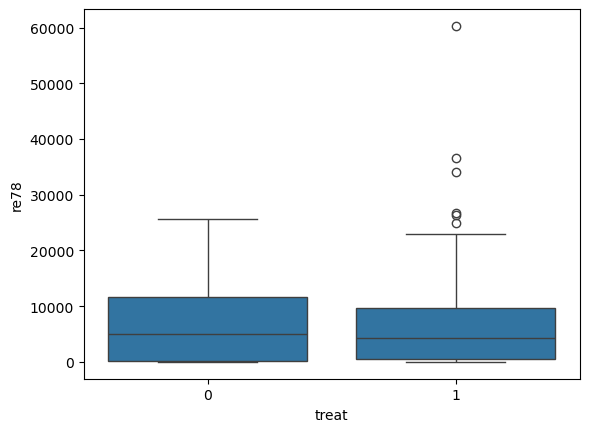

In [29]:
df_data = df[["treat", "re78"]]
ax = sns.boxplot(x="treat", y="re78", data=df_data)
plt.show()

We see that 
- treated : the mean income is less than for the control group, the upper 75% q is also less but the 25%q is higher. We also see that the treated group has more outliers that are very high
- control : lower max then trated, but on avg more incomes than treaed. We also have more data for control than for treated

- the control group is thus better in this naive test

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [64]:
df_treated = df[df["treat"] == 1]
df_control = df[df["treat"] == 0]

In [65]:
df_control.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


In [66]:
df_treated.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [67]:
df_control = df_control.drop(columns=["id", "treat"])
df_treated = df_treated.drop(columns=["id", "treat"])
df_control_cont = df_control[["age", "educ", "re74", "re75"]]
df_treated_cont = df_treated[["age", "educ", "re74", "re75"]]

df_control_bin = df_control[["black", "hispan", "married", "nodegree"]]
df_treated_bin = df_treated[["black", "hispan", "married", "nodegree"]]

df_control_cont = (df_control_cont - df_control_cont.mean()) / df_control_cont.std()
df_treated_cont = (df_treated_cont - df_treated_cont.mean()) / df_treated_cont.std()

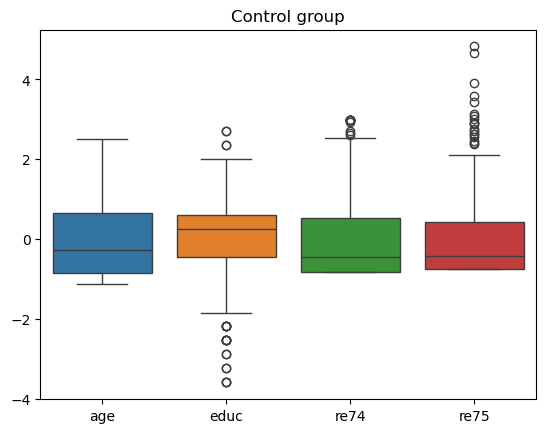

In [70]:
sns.boxplot(df_control_cont)
plt.title("Control group")
plt.show()

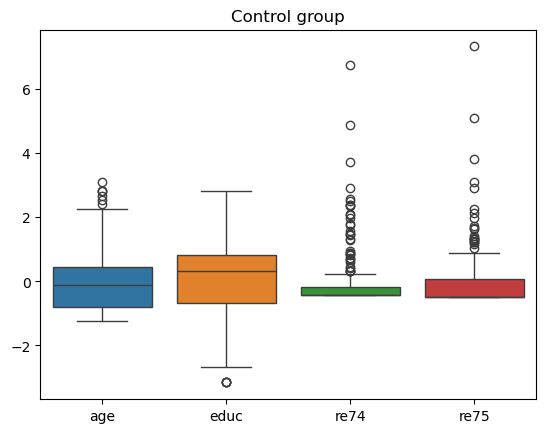

In [62]:
sns.boxplot(df_treated_cont)
plt.title("Control group")
plt.show()

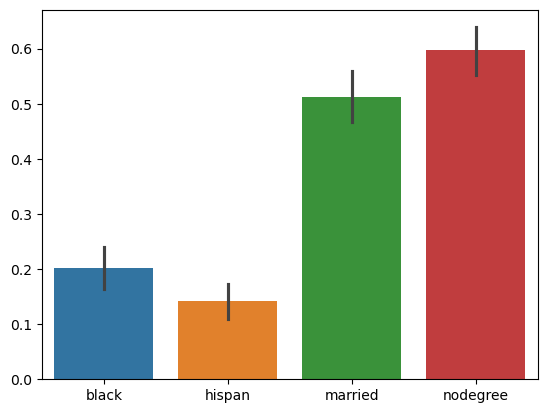

In [68]:
sns.barplot(data=df_control_bin)
plt.show()

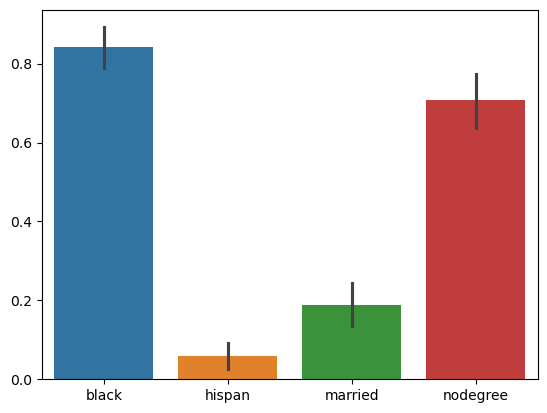

In [71]:
sns.barplot(data=df_treated_bin)
plt.show()

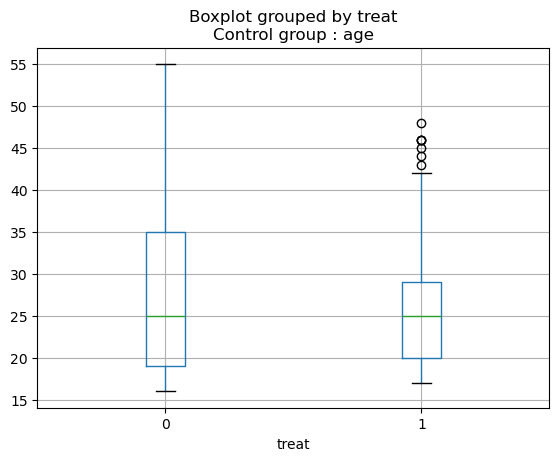

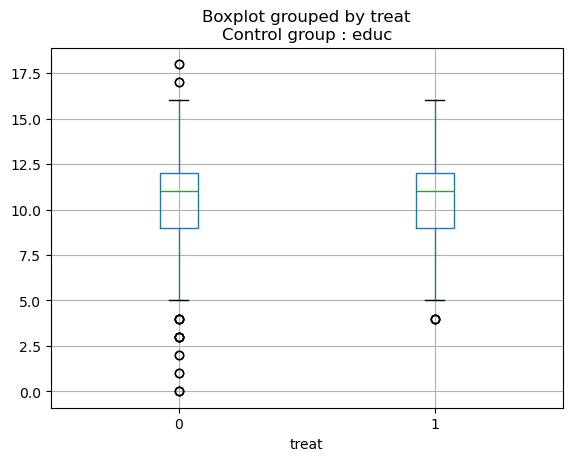

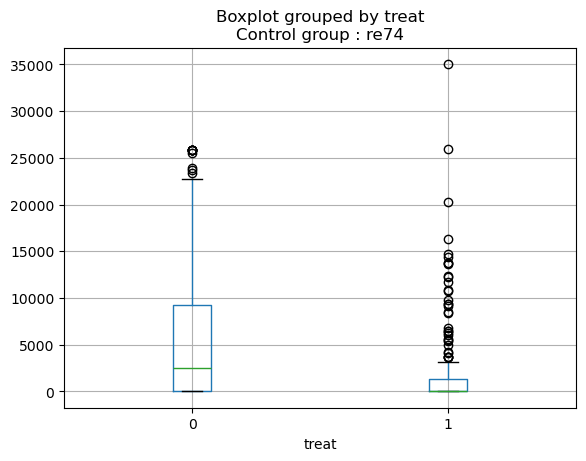

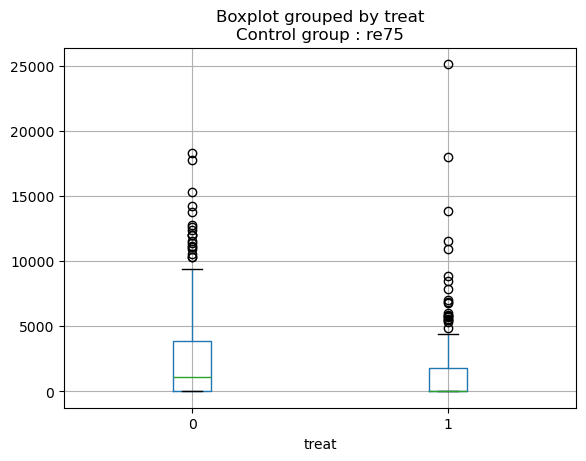

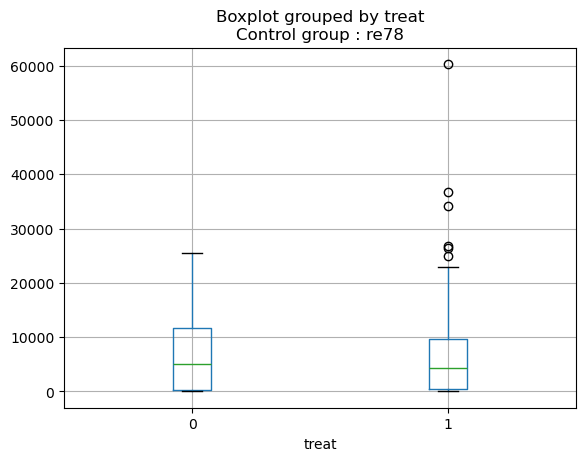

In [73]:
elems = ["age", "educ", "re74", "re75", "re78"]
for elem in elems:
    df.boxplot(by="treat", column=elem)
    plt.title(f"Control group : {elem}")
    plt.show()

 There are more not married black people in the the treatment thant in the control. We thus have two different populations. Moreover the control group is older than the treated group. re74 and re75 is also much lower for treatment group suggeting that they started with low employment rates or smaller jobs

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [146]:
df["age"] = (df["age"] - df["age"].mean()) / df["age"].std()
df["educ"] = (df["educ"] - df["educ"].mean()) / df["educ"].std()
df["re74"] = (df["re74"] - df["re74"].mean()) / df["re74"].std()
df["re75"] = (df["re75"] - df["re75"].mean()) / df["re75"].std()

mod = smf.logit(formula='treat ~ C(black) + C(hispan) + C(married) + C(nodegree) + age + educ + re74 + re75', data=df)
res = mod.fit()

df["propensity"] = res.predict()    

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Thu, 17 Oct 2024   Pseudo R-squ.:                  0.3508
Time:                        17:49:51   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [85]:
df_treated = df[df["treat"] == 1]
df_control = df[df["treat"] == 0]


G = nx.Graph()

for idx1, row1 in df_treated.iterrows():
    for idx2, row2 in df_control.iterrows():
        G.add_weighted_edges_from([(idx1, idx2, 1-abs(row1["propensity"] - row2["propensity"]))])        
        
matching = nx.max_weight_matching(G)


In [133]:
df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [134]:
indices = []
for elem in matching:
    indices.append(elem[0])
    indices.append(elem[1])

In [135]:
balanced = df.loc[indices]
balanced.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,0.500000,25.559459,10.475676,0.656757,0.137838,0.200000,0.672973,2218.840626,1573.400219,5901.959790
std,0.500677,9.026488,2.357184,0.475435,0.345197,0.400542,0.469762,4569.739381,2936.786018,7028.505472
min,0.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.771123
50%,0.500000,23.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.854840,3886.808000
75%,1.000000,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1949.960000,1890.133250,9082.846000
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [136]:
df_control = balanced[balanced["treat"] == 0]
df_treated = balanced[balanced["treat"] == 1]

In [137]:
df_control["re78"].describe()

count      185.000000
mean      5454.776050
std       6063.836916
min          0.000000
25%          0.000000
50%       3358.873000
75%       7933.914000
max      23764.800000
Name: re78, dtype: float64

In [138]:
df_treated["re78"].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [139]:
df_control = df_control.drop(columns=["id", "treat"])
df_treated = df_treated.drop(columns=["id", "treat"])
df_control_cont = df_control[["age", "educ", "re74", "re75"]]
df_treated_cont = df_treated[["age", "educ", "re74", "re75"]]

df_control_bin = df_control[["black", "hispan", "married", "nodegree"]]
df_treated_bin = df_treated[["black", "hispan", "married", "nodegree"]]

df_control_cont = (df_control_cont - df_control_cont.mean()) / df_control_cont.std()
df_treated_cont = (df_treated_cont - df_treated_cont.mean()) / df_treated_cont.std()

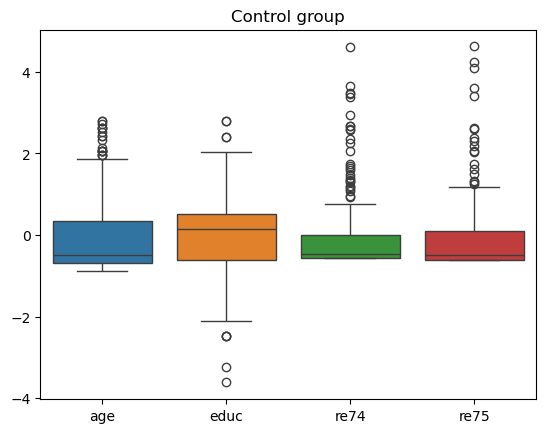

In [140]:
sns.boxplot(df_control_cont)
plt.title("Control group")
plt.show()

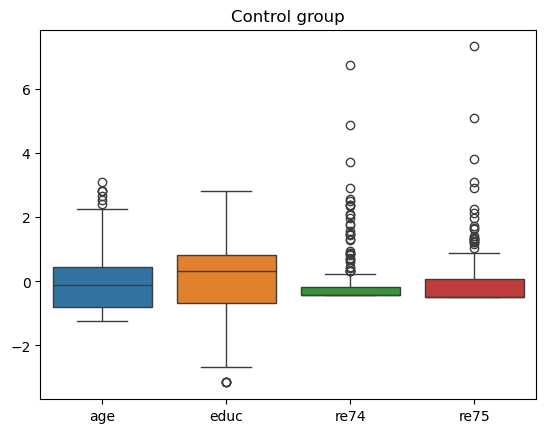

In [141]:
sns.boxplot(df_treated_cont)
plt.title("Control group")
plt.show()

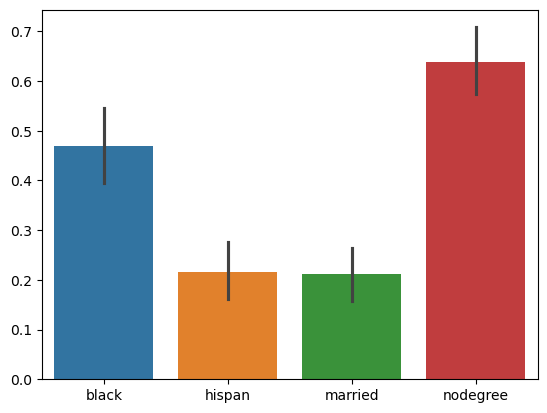

In [142]:
sns.barplot(data=df_control_bin)
plt.show()

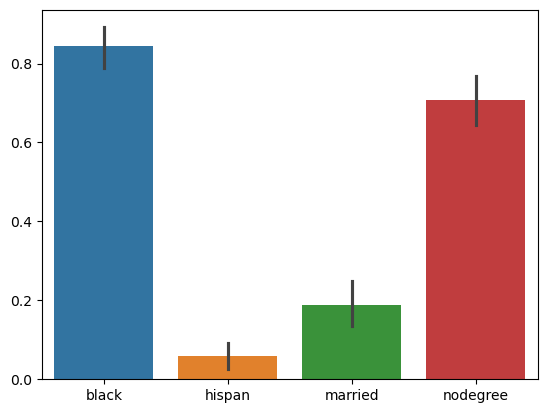

In [143]:
sns.barplot(data=df_treated_bin)
plt.show()

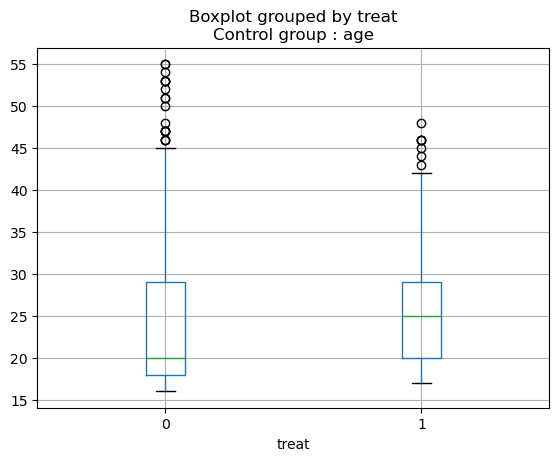

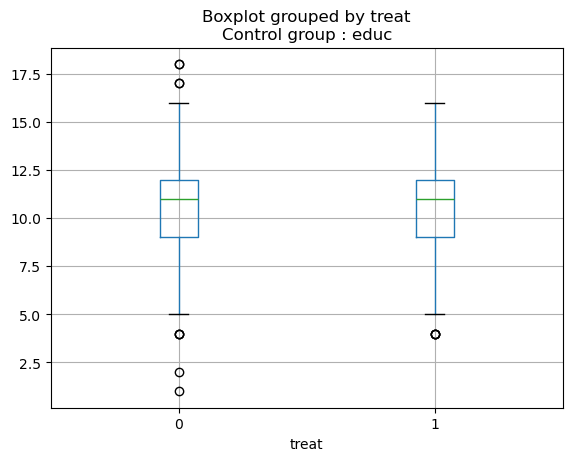

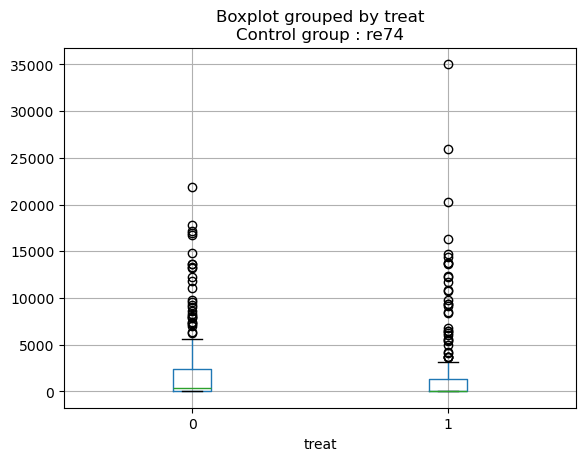

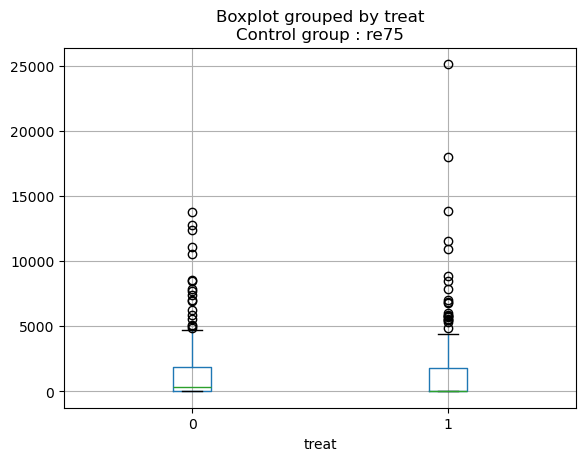

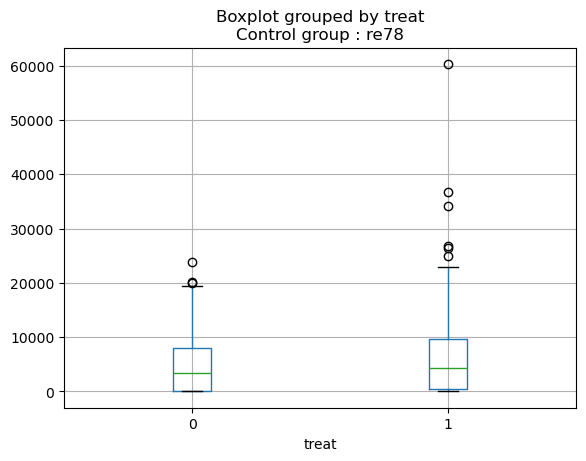

In [144]:
elems = ["age", "educ", "re74", "re75", "re78"]
for elem in elems:
    balanced.boxplot(by="treat", column=elem)
    plt.title(f"Control group : {elem}")
    plt.show()

We see that after our matching the classes are more balanced and now we could use this group to gain more interesting insights on the data. 
there are still some inbalances in the race like for black people and hispanic people

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [148]:
df_treated = df[df["treat"] == 1]
df_control = df[df["treat"] == 0]


G = nx.Graph()

for idx1, row1 in df_treated.iterrows():
    for idx2, row2 in df_control.iterrows():
        if row1["black"] == row2["black"] and row1["hispan"] == row2["hispan"] :
            
            G.add_weighted_edges_from([(idx1, idx2, 1-abs(row1["propensity"] - row2["propensity"]))])        
        
matching = nx.max_weight_matching(G)

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [149]:
indices = []
for elem in matching:
    indices.append(elem[0])
    indices.append(elem[1])

In [150]:
balanced = df.loc[indices]
balanced.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,0.500000,-0.147119,-0.007126,0.750000,0.094828,0.258621,0.646552,-0.250222,-0.102245,5630.943889,0.493644
std,0.501081,0.922289,0.945145,0.433949,0.293610,0.438823,0.479074,0.834643,1.028428,6367.498345,0.238546
min,0.000000,-1.149982,-3.526478,0.000000,0.000000,0.000000,0.000000,-0.703546,-0.662971,0.000000,0.024896
25%,0.000000,-0.846375,-0.482714,0.750000,0.000000,0.000000,0.000000,-0.703546,-0.662971,23.274195,0.282742
50%,0.500000,-0.441566,0.278227,1.000000,0.000000,0.000000,1.000000,-0.703546,-0.656452,3494.377000,0.599772
75%,1.000000,0.266851,0.658697,1.000000,0.000000,1.000000,1.000000,-0.223103,0.040071,9107.598000,0.686305
max,1.000000,2.796912,2.561050,1.000000,1.000000,1.000000,1.000000,4.705571,6.965879,36646.950000,0.789723


In [151]:
df_control = balanced[balanced["treat"] == 0]
df_treated = balanced[balanced["treat"] == 1]

In [152]:
df_control["re78"].describe()

count      116.000000
mean      5095.456025
std       6047.014862
min          0.000000
25%          0.000000
50%       2256.488500
75%       8942.092750
max      20243.380000
Name: re78, dtype: float64

In [153]:
df_treated["re78"].describe()

count      116.000000
mean      6166.431753
std       6655.656670
min          0.000000
25%        672.490925
50%       4300.659000
75%      10001.218250
max      36646.950000
Name: re78, dtype: float64

In [154]:
df_control = df_control.drop(columns=["id", "treat"])
df_treated = df_treated.drop(columns=["id", "treat"])
df_control_cont = df_control[["age", "educ", "re74", "re75"]]
df_treated_cont = df_treated[["age", "educ", "re74", "re75"]]

df_control_bin = df_control[["black", "hispan", "married", "nodegree"]]
df_treated_bin = df_treated[["black", "hispan", "married", "nodegree"]]

df_control_cont = (df_control_cont - df_control_cont.mean()) / df_control_cont.std()
df_treated_cont = (df_treated_cont - df_treated_cont.mean()) / df_treated_cont.std()

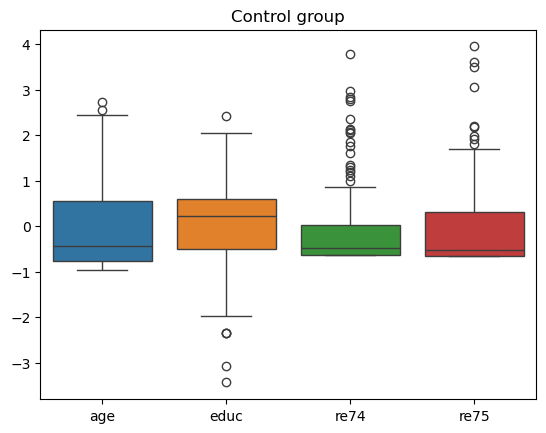

In [155]:
sns.boxplot(df_control_cont)
plt.title("Control group")
plt.show()

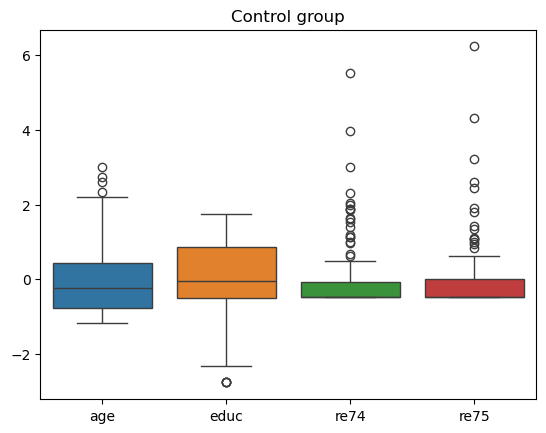

In [156]:
sns.boxplot(df_treated_cont)
plt.title("Control group")
plt.show()

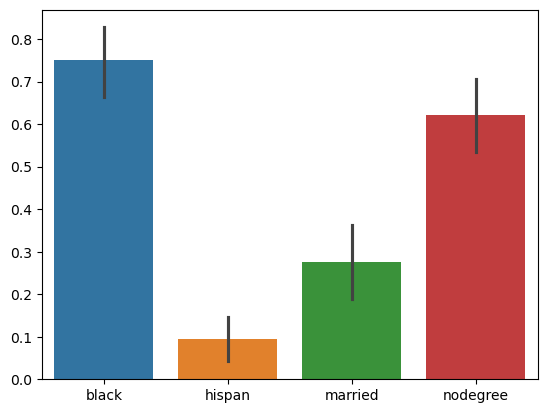

In [157]:
sns.barplot(data=df_control_bin)
plt.show()

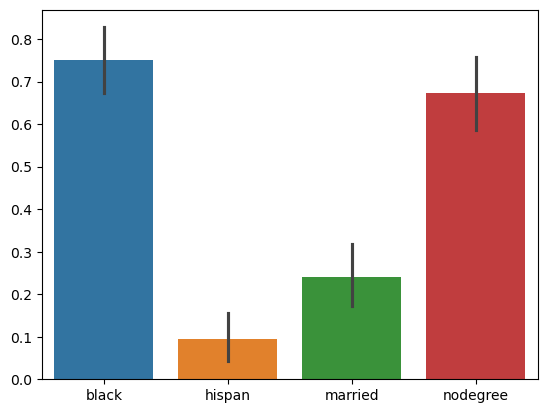

In [158]:
sns.barplot(data=df_treated_bin)
plt.show()

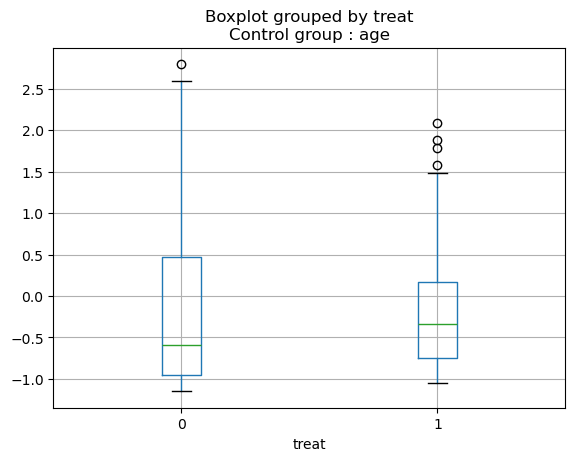

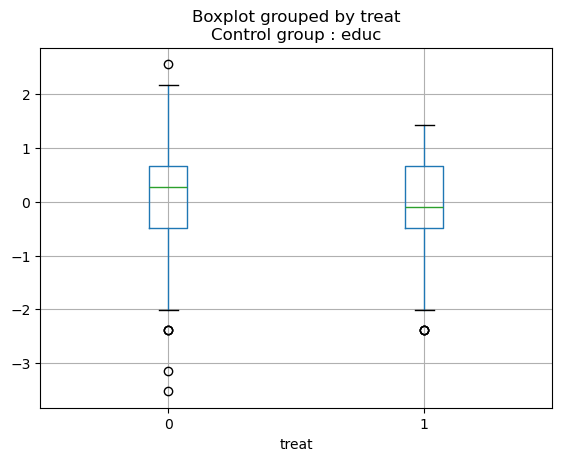

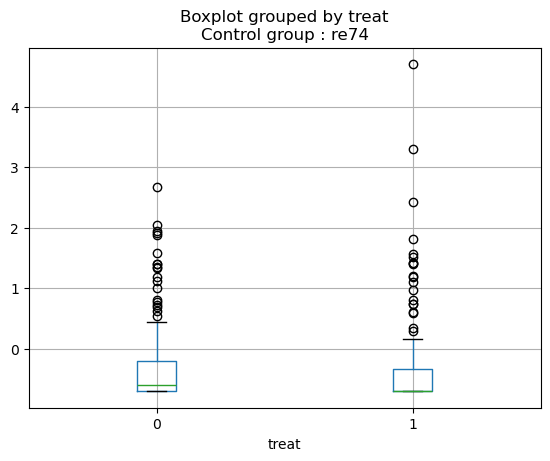

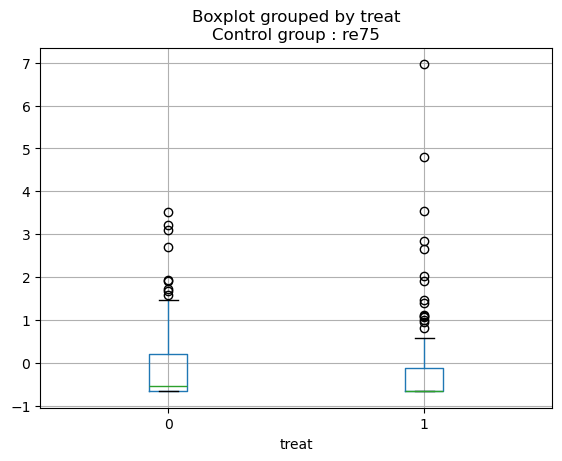

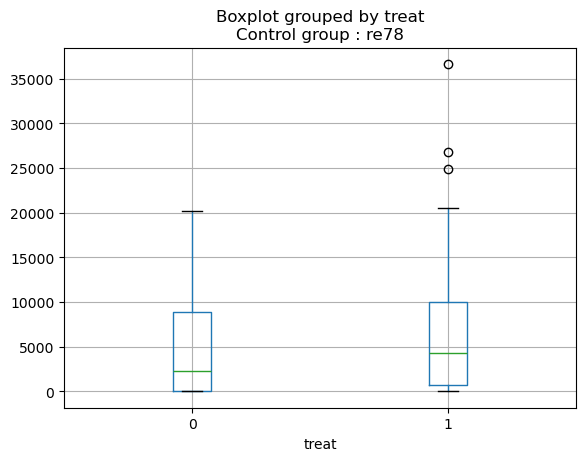

In [159]:
elems = ["age", "educ", "re74", "re75", "re78"]
for elem in elems:
    balanced.boxplot(by="treat", column=elem)
    plt.title(f"Control group : {elem}")
    plt.show()

Everything is balanced now !

And we see that the treatment nearly doubled the median income with some hard outliers